<a href="https://colab.research.google.com/github/yue-zhongqi/cartpole_colab/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial and Sample Code for Balancing a Pole on a Cart

## Installing dependencies:

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install tensorflow
!pip install moviepy

The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.
The system cannot find the path specified.


The system cannot find the path specified.
The system cannot find the path specified.


The system cannot find the path specified.


### <font color='blue'> for mac !pip install tensorflow-macos <font>

## Importing dependencies and define helper functions

In [2]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
import time
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [3]:
env = gym.make("CartPole-v1")

In [4]:
help(env)

Help on TimeLimit in module gym.wrappers.time_limit object:

class TimeLimit(gym.core.Wrapper)
 |  TimeLimit(env: gym.core.Env, max_episode_steps: Optional[int] = None)
 |  
 |  This wrapper will issue a `truncated` signal if a maximum number of timesteps is exceeded.
 |  
 |  If a truncation is not defined inside the environment itself, this is the only place that the truncation signal is issued.
 |  Critically, this is different from the `terminated` signal that originates from the underlying environment as part of the MDP.
 |  
 |  Example:
 |     >>> from gym.envs.classic_control import CartPoleEnv
 |     >>> from gym.wrappers import TimeLimit
 |     >>> env = CartPoleEnv()
 |     >>> env = TimeLimit(env, max_episode_steps=1000)
 |  
 |  Method resolution order:
 |      TimeLimit
 |      gym.core.Wrapper
 |      gym.core.Env
 |      typing.Generic
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env: gym.core.Env, max_episode_steps: Optional[int] = Non

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [5]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [6]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [7]:
observation = env.reset()

print("Initial observations:", observation)

Initial observations: (array([-0.04433606, -0.00641213, -0.03645328,  0.03746203], dtype=float32), {})


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

The **episode ends** if any one of the following occurs:<br>
**Termination**: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display) <br>
**Termination**: Pole Angle is greater than ±12° (±0.20944 rad)<br>
**Truncation**: Episode length is greater than 500.


In [8]:
# step(x): Choose an action (0 or 1)
observation, reward, terminated, truncated, info = env.step(1)

# Observation: Cart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip
print("New observations after choosing action 0:", observation)

# Reward: 1 for every step taken, including the termination step
print("Reward for this step:", reward)

# Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
# Termination: Pole Angle is greater than ±12° (±0.20944 rad)
print("Is this round terminated?", terminated)

# Truncation: Episode length is greater than 500
print("Is this round truncated?", truncated)

New observations after choosing action 0: [-0.04446431  0.18921308 -0.03570404 -0.26649573]
Reward for this step: 1.0
Is this round terminated? False
Is this round truncated? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [9]:
observation = env.reset()
cumulative_reward = 0
truncated = terminated = False

# Putting trunctated only will result in a 500 episode lenth before it terminates
print("\t\t\t\t\tCart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip")

while not (truncated or terminated):
    observation, reward, terminated,truncated, info = env.step(0)
    print(f"New observations after choosing action {int(cumulative_reward)}:", observation)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)
print("Is this round terminated?", terminated)
print("Is this round truncated?", truncated)

					Cart Position, Cart Velocity, Pole Angle, Pole Velocity At Tip
New observations after choosing action 0: [ 0.01519689 -0.22263257 -0.0406186   0.26657018]
New observations after choosing action 1: [ 0.01074424 -0.417152   -0.0352872   0.54617006]
New observations after choosing action 2: [ 0.0024012 -0.6117608 -0.0243638  0.8275293]
New observations after choosing action 3: [-0.00983402 -0.8065413  -0.00781321  1.1124511 ]
New observations after choosing action 4: [-0.02596484 -1.0015597   0.01443581  1.4026728 ]
New observations after choosing action 5: [-0.04599604 -1.196858    0.04248926  1.6998336 ]
New observations after choosing action 6: [-0.06993321 -1.3924431   0.07648594  2.0054345 ]
New observations after choosing action 7: [-0.09778206 -1.5882742   0.11659463  2.3207872 ]
New observations after choosing action 8: [-0.12954755 -1.7842479   0.16301037  2.646953  ]
New observations after choosing action 9: [-0.16523251 -1.9801794   0.21594943  2.9846675 ]
Cumulative rewar

# Sample Codes

## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [10]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

For Task 1, we can show the observation and chosen action below:

In [11]:
observation = env.reset()
action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: (array([-0.01588226,  0.00387222,  0.0267293 ,  0.0054873 ], dtype=float32), {})
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

[233 157 233 244 203 161 212 196 245 195 176 183 198 165 222 158 166 162
 153 248 197 168 229 247 191 163 230 157 167 176 189 180 172 242 162 185
 204 198 160 179 160 227 245 244 236 172 223 246 169 157 168 229 166 214
 182 220 244 237 244 200 239 188 240 244 178 222 242 238 157 162 221 196
 158 156 168 232 201 174 184 244 187 187 232 242 234 231 176 169 157 171
 219 249 158 188 180 175 211 244 236 245]


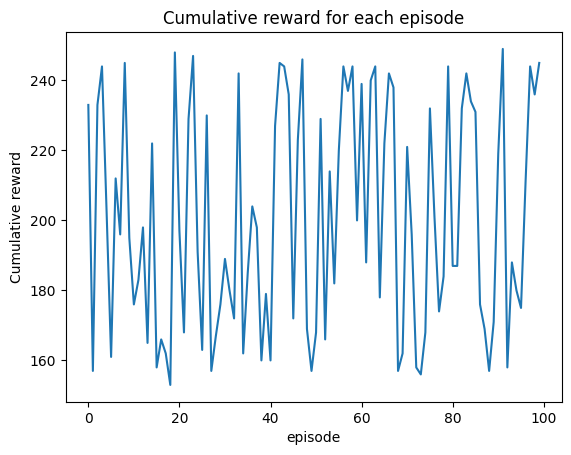

In [12]:
episode_results = np.random.randint(150, 250, size=100)
print(episode_results)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [13]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 200.24
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [14]:
env = RecordVideo(gym.make("CartPole-v1",render_mode = "human"),"./video")

# run for 10 episodes
for episode in range(10):
  observation = env.reset()
  while True:
      env.render()
      #your agent goes here
      action = rand_policy_agent(observation)
      observation, reward, terminated,truncated, info = env.step(action) 
      if terminated: 
        break;    
env.close()
show_video()

Could not find video


# <font color='lightgreen'> Our implementation </font>

We selected the "Q Learning" model-free, off-policy reinforcement learning that will find the best course of action, given the current state of the agent. 


## Task 1: Development of an RL agent

Creating a Q table<br>

We also need to define the number of states and actions.

Since the environment is a continuous observation space, we need to convert it into a discete observation space.
 - If we print the state (or observation space) of our cartpole environment, we realise that it is continuous and gives us way too many pairs of action and state pairs to be considered for our Q-table 
 - Therefore, we will be converting the continuous state space using the user-defined function Discrete(state,bins)


We will be converting the continuous state space using the user-defined function Discrete(state,bins)

We will also define Qtable, a funciton to create a Q-Table, it will return a tuple of the with bins of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [16]:
# CART POLE, make the environment
env = gym.make('CartPole-v1')

# Q-Table
def Qtable(state_space,action_space,bin_size = 30):
    # Create bins for each state, corresponding to cart position, velocity and pole angle, angular velocity.
    #np.linspace(): returns evenly spaced numbers over a specified interval
    #syntax: np.linspace(start_val, end_val, num_of_samples_generated) 
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    
    # Create Q-Table with all zeros
    q_table = np.zeros(shape=([bin_size] * state_space + [action_space]))

    #print(q_table.shape)

    return q_table, bins

q_table , bins = Qtable(len(env.observation_space.low),env.action_space.n)

# Discretize the state
def Discrete(state, bins):

    index = []

    #np.digitize(): return the indices of the bins to which each value in input array belongs.
    #syntax: np.digitize(x, bins) -- where x = input array to be binned, bins = array of bins
    for i in range(len(state)): 
        index.append(np.digitize(state[i],bins[i]) - 1)

    return tuple(index)

Definining the Q Learning Agent

In [17]:
def Q_learning(q_table, bins, episodes, gamma, lr, epsilon):

    show_every = 100 
    rewards = 0
    steps = 0 
    runs = [0]
    solved = False

    #start_epsilon_decaying = 1 
    #end_epsilon_decaying = episodes//2 
    #epsilon_decay_value = epsilon/(end_epsilon_decaying - start_epsilon_decaying)
    
    for episode in range(episodes):
        
        current_state = Discrete(env.reset()[0],bins) # initial observation
        score = 0
        steps = 0 
        terminated = truncated =  False
        
        while not (terminated or truncated):

            steps += 1 

            # Epsilon-greedy policy   
            if np.random.uniform(0,1) < epsilon: 
                # explore 
                action = env.action_space.sample()
            else: 
                # exploit 
                action = np.argmax(q_table[current_state])
            
            # Take action
            observation, reward, terminated, truncated, info = env.step(action)
            next_state = Discrete(observation,bins)

            score += reward
            
            if episode%show_every == 0:
                env.render()

            # Update Q-Table
            if not (terminated or truncated):
                # Find the maximum Q-value for the next state
                max_future_q = np.max(q_table[next_state])
                # Get the current Q-value for the current state
                current_q = q_table[current_state+(action,)]
                # Calculate the new Q-value via Temporal Difference
                new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                # Assign new Q-value to the Q-table
                q_table[current_state+(action,)] = new_q

            # Update the current state
            current_state = next_state


        # End of the loop update
        else:
            rewards += score
            runs.append(score)
            if score > 195 and steps >= 100 and solved == False: # considered as a solved:
                solved = True
                print('Solved in episode : {}'.format(episode))
                print("Episode, Steps, Score, Rewards: {}, {}, {}, {}".format(episode, steps, score, rewards))
                print("Terminated? {}, Truncated? {}".format(terminated, truncated))
        
        #if end_epsilon_decaying >= episode >= start_epsilon_decaying: 
            # epsilon -= epsilon_decay_value

env.close()

In [18]:
#Genereate q table with bins
q_table, bins = Qtable((env.observation_space.shape[0]), env.action_space.n)

# Train the agent
Q_learning(q_table, bins, lr = 0.15, gamma = 0.995, episodes = 5*10**3, epsilon= 0.2)


Solved in episode : 453
Episode, Steps, Score, Rewards: 453, 222, 222.0, 19186.0
Terminated? True, Truncated? False


In [35]:
def q_policy_agent(observation, q_table, bins):
    return np.argmax(q_table[Discrete(observation,bins)])

For Task 1, we can show the observation and chosen action below:

In [36]:
observation = env.reset()
action = q_policy_agent(observation[0], q_table, bins)
print("Observation:", observation)
print("Chosen action:", action)

Observation: (array([-0.01686957, -0.00323947,  0.04778847,  0.00458237], dtype=float32), {})
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

In [ ]:
# Test the agent
episode_results = {'episode':[],'rewards':[]}

for i in range(100):
    current_state = Discrete(env.reset()[0],bins) # initial observation
    rewards = 0
    episode = 1
    terminated = truncated =  False
    while not (terminated or truncated):
        # Choose the best action according to the Q-table
        action = np.argmax(q_table[current_state])
        
        # Take the action and observe the next state and reward
        observation, reward, terminated, truncated, info = env.step(action)
        
        # Update the state and the round
        current_state = Discrete(observation,bins)
        rewards += reward
        episode += 1
    # Update the score
    episode_results['rewards'].append(rewards)
    episode_results['episode'].append(episode)


plt.plot(episode_results['rewards'])
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()


Print the average reward over the 100 episodes.

In [ ]:
print("Average cumulative reward:", np.array(episode_results['rewards']).mean())
print("Is my agent good enough?", np.array(episode_results['rewards']).mean() > 195)

Average cumulative reward: 452.12
Is my agent good enough? True


## Task 3: Render one episode played by the agent

In [ ]:
env = RecordVideo(gym.make("CartPole-v1",render_mode = "human"),"./video")
# run for 10 episodes
for episode in range(10):
  observation = env.reset()
  observation = observation[0]
  print(observation)
  while True:
      env.render()
      #your agent goes here
      action = q_policy_agent(observation,q_table,bins)
      observation, reward, terminated,truncated, info = env.step(action) 
      if terminated: 
        break;
      
env.close()
show_video()

[-0.04476569  0.03822781 -0.01229822 -0.00812363]


TypeError: object of type 'numpy.float32' has no len()